In [1]:
import sys
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import sqlalchemy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, VarianceThreshold

import tensorflow
from tensorflow import keras
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

import kerastuner as kt
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization

from ann_visualizer.visualize import ann_viz
import graphviz



sys.path.append("../Shared/")
from DataService import DataService

sys.path.append("../Datasets/")
# print(os.getcwd())
from DataCreation import getDatasetV1, getDatasetV2, getDatasetV3, getDatasetV4
from DataTestSplit import splitData



/home/student/dodhiajk/CGC_Grain_Outcome_Predictions/.venv/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/student/dodhiajk/CGC_Grain_Outcome_Predictions/.venv/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/tmp/ipykernel_1017537/2652727627.py:10: DeprecationWarning

In [2]:
tensorflow.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tensorflow.config.set_visible_devices(tensorflow.config.list_physical_devices('CPU'), 'CPU')  # Show CPU devices

2023-07-29 13:34:14.352618: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-07-29 13:34:14.352642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: woodswallow-02.cs.umanitoba.ca
2023-07-29 13:34:14.352647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: woodswallow-02.cs.umanitoba.ca
2023-07-29 13:34:14.352720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.125.6
2023-07-29 13:34:14.352738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 510.108.3
2023-07-29 13:34:14.352742: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 510.108.3 does not match DSO version 525.125.6 -- cannot find working 

In [3]:
from typing import List, Optional, Tuple
def extractYears(df: pd.DataFrame, year: int, yearEnd: Optional[int] = None) -> pd.DataFrame:
    """Extract the rows of a dataframe that correspond to a given year.

    Args:
        df (pd.DataFrame): The dataframe to extract from.
        year (int): The year to extract.
        yearEnd (int, optional): The end year to extract. Defaults to None.

    Returns:
        pd.DataFrame: The extracted dataframe.
    """
    
    if yearEnd is None:
        return df.loc[df["year"] == year]
    else:
        return df.loc[(df["year"] >= year) & (df["year"] <= yearEnd)]

In [40]:
load_dotenv()
PG_DB = os.getenv("POSTGRES_DB")
PG_ADDR = os.getenv("POSTGRES_ADDR")
PG_PORT = os.getenv("POSTGRES_PORT")
PG_USER = os.getenv("POSTGRES_USER")
PG_PW = os.getenv("POSTGRES_PW")

if (
    PG_DB is None
    or PG_ADDR is None
    or PG_PORT is None
    or PG_USER is None
    or PG_PW is None
):
    raise ValueError("Environment variables not set")

# connecting to database
db = DataService(PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)
conn = db.connect()

In [41]:
weatherStationQuery = sq.text("""
    SELECT * from dataset_monthly_station
""")

weatherSatQuery = sq.text("""
    SELECT * from dataset_monthly_sat
""")

ergotPrevYearsAggQuery = sq.text("""
    SELECT year, district, 
    present_prev1, present_prev2, present_prev3,
    percnt_true_prev1, percnt_true_prev2, percnt_true_prev3 
    from agg_ergot_sample_v2
""")

ergotTargetQuery = sq.text("""
    SELECT year, district, downgrade from ergot_sample_feat_eng
""")

In [42]:
stationDf = pd.read_sql(weatherStationQuery, conn)
satelliteDf = pd.read_sql(weatherSatQuery, conn)
ergotPrevDf = pd.read_sql(ergotPrevYearsAggQuery, conn)
ergotTargetDf = pd.read_sql(ergotTargetQuery, conn)

conn.close()
del conn

In [43]:
ergotTargetDf.drop_duplicates( inplace=True)
ergotTargetDf

,year,district,downgrade
0,1995,4810,False
48,1995,4820,False
190,1995,4830,False
230,1995,4840,False
280,1995,4840,True
...,...,...,...
157041,2022,4751,True
157126,2022,4791,True
157219,2022,4731,True
157727,2022,4604,True


In [44]:
ergotPrevDf.fillna(0, inplace=True)
ergotPrevDf

,year,district,present_prev1,present_prev2,present_prev3,percnt_true_prev1,percnt_true_prev2,percnt_true_prev3
0,1995,4810,False,False,False,0.000000,0.000000,0.000000
1,1995,4820,False,False,False,0.000000,0.000000,0.000000
2,1995,4830,False,False,False,0.000000,0.000000,0.000000
3,1995,4840,False,False,False,0.000000,0.000000,0.000000
4,1995,4850,False,False,False,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
1087,2022,4761,False,True,True,0.010204,0.076923,0.062893
1088,2022,4771,False,True,False,0.000000,0.153333,0.013072
1089,2022,4790,True,True,True,0.025316,0.229167,0.147727
1090,2022,4791,False,True,True,0.028986,0.223881,0.328571


In [45]:
stationDf

,year,month,district,min_temp_x,max_temp_x,mean_temp_x,min_dew_point_temp,max_dew_point_temp,mean_dew_point_temp,min_humidex,...,mean_total_rain,min_total_snow,max_total_snow,mean_total_snow,min_total_precip,max_total_precip,mean_total_precip,min_snow_on_grnd,max_snow_on_grnd,mean_snow_on_grnd
0,1953,1,4606,-37.2,-3.3,-16.650918,-22.2,0.0,-3.170833,0.0,...,0.000000,0.0,18.3,1.375000,0.0,18.3,1.375000,0.0,0.0,0.000000
1,1953,1,4607,-31.7,-4.4,-14.224855,-33.9,-5.0,-14.939367,0.0,...,0.000000,0.0,2.8,0.466667,0.0,2.8,0.466667,0.0,0.0,0.000000
2,1953,1,4611,-31.7,-5.0,-13.608918,-32.2,-5.6,-14.508056,0.0,...,0.000000,0.0,7.4,1.366667,0.0,7.4,1.366667,0.0,0.0,0.000000
3,1953,1,4612,-38.9,-7.2,-23.922143,-40.0,0.0,-23.888548,0.0,...,0.000000,0.0,3.8,0.439583,0.0,3.8,0.439583,0.0,0.0,0.000000
4,1953,1,4710,-33.9,3.3,-11.815733,-33.9,-1.1,-12.818630,0.0,...,0.000000,0.0,2.5,0.220000,0.0,2.5,0.220000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22602,2022,12,4830,-46.5,11.7,-11.121018,-51.8,2.8,-13.209914,0.0,...,0.000357,0.0,7.2,0.028596,0.0,8.4,0.420344,0.0,49.0,4.857147
22603,2022,12,4840,-41.9,5.9,-17.592067,-46.0,2.7,-20.147237,0.0,...,0.000000,0.0,12.6,0.030833,0.0,8.7,0.501989,0.0,44.0,4.498098
22604,2022,12,4850,-41.8,9.9,-16.074466,-46.6,1.5,-19.138173,0.0,...,0.000000,0.0,2.7,0.022471,0.0,10.0,0.291207,0.0,36.0,5.410004
22605,2022,12,4860,-48.1,4.9,-18.400136,-52.4,0.4,-20.571919,0.0,...,0.000000,0.0,15.5,0.052028,0.0,10.1,0.570979,0.0,47.0,7.136807


In [46]:
# merge on year and district
# tempdf = pd.merge(satelliteDf, ergotPrevDf, on=["year", "district"], how="left")
# del satelliteDf
# del ergotPrevDf
# tempdf = satelliteDf
tempdf = stationDf

# merge on year and district
datasetDf = pd.merge(ergotTargetDf, tempdf, on=["year", "district"], how="left")
datasetDf = pd.merge(datasetDf, ergotPrevDf, on=["year", "district"], how="left")
del ergotTargetDf
del tempdf

In [47]:
datasetDf

,year,district,downgrade,month,min_temp_x,max_temp_x,mean_temp_x,min_dew_point_temp,max_dew_point_temp,mean_dew_point_temp,...,mean_total_precip,min_snow_on_grnd,max_snow_on_grnd,mean_snow_on_grnd,present_prev1,present_prev2,present_prev3,percnt_true_prev1,percnt_true_prev2,percnt_true_prev3
0,1995,4810,False,1.0,-29.5,11.1,-10.052509,-31.9,4.8,-12.584334,...,0.103226,0.0,9.0,1.612903,False,False,False,0.000000,0.000000,0.000000
1,1995,4810,False,2.0,-26.1,20.0,-5.029997,-29.9,4.1,-10.819124,...,0.078929,0.0,8.0,0.326786,False,False,False,0.000000,0.000000,0.000000
2,1995,4810,False,3.0,-28.4,17.3,-1.511578,-32.2,5.6,-8.330515,...,0.293871,0.0,8.0,0.804839,False,False,False,0.000000,0.000000,0.000000
3,1995,4810,False,4.0,-14.8,19.0,3.551604,-21.3,9.1,-2.984549,...,0.603000,0.0,14.0,0.471667,False,False,False,0.000000,0.000000,0.000000
4,1995,4810,False,5.0,-4.6,31.5,11.397211,-10.2,11.2,2.413164,...,1.340645,0.0,0.0,0.000000,False,False,False,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18658,2022,4830,True,8.0,-2.0,34.6,18.476221,-6.6,20.6,7.039598,...,1.161233,0.0,0.0,0.000000,False,True,True,0.025641,0.513369,0.083333
18659,2022,4830,True,9.0,-6.3,36.9,13.501864,-30.9,15.6,2.855264,...,0.615462,0.0,4.0,0.066177,False,True,True,0.025641,0.513369,0.083333
18660,2022,4830,True,10.0,-10.6,28.3,7.661494,-21.0,13.0,-0.843584,...,0.826722,0.0,45.0,0.929443,False,True,True,0.025641,0.513369,0.083333
18661,2022,4830,True,11.0,-31.5,13.4,-6.694053,-38.8,1.9,-10.254210,...,0.836543,0.0,38.0,3.963579,False,True,True,0.025641,0.513369,0.083333


In [48]:
mean = datasetDf.mean()
datasetDf.fillna(mean, inplace=True)
t = pd.get_dummies(datasetDf["district"], drop_first=True)
datasetDf = pd.concat([datasetDf, t], axis=1)
datasetDf.columns = datasetDf.columns.astype(str)
datasetDf.drop(["district"], axis=1, inplace=True)

In [49]:
df = datasetDf.copy()

In [50]:
datasetDf.duplicated().sum()
datasetDf.drop_duplicates(inplace=True)

In [51]:
# train 1995 - 2015 test 2016 - 2020
X_train, X_val, X_test, y_train, y_val, y_test = splitData(datasetDf, drop_features=["year"], target_variable="downgrade", pivot=2015, val_size=0.2, stratified=False)
del datasetDf

/home/student/dodhiajk/CGC_Grain_Outcome_Predictions/src/Models/../Datasets/DataTestSplit.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=drop_features, inplace=True)
/home/student/dodhiajk/CGC_Grain_Outcome_Predictions/src/Models/../Datasets/DataTestSplit.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=drop_features, inplace=True)


In [52]:
X_train.describe()

,month,min_temp_x,max_temp_x,mean_temp_x,min_dew_point_temp,max_dew_point_temp,mean_dew_point_temp,min_humidex,max_humidex,mean_humidex,...,4781,4790,4791,4810,4820,4830,4840,4850,4860,4870
count,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.0,10528.000000,10528.000000,...,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000
mean,6.498867,-14.936495,19.911602,2.726373,-18.836940,10.092976,-2.287803,0.0,14.812620,1.669267,...,0.002850,0.034005,0.025551,0.023651,0.030015,0.028210,0.033720,0.033055,0.025171,0.025076
std,3.445290,15.158842,11.227308,11.948179,15.196806,8.227338,10.137629,0.0,17.120103,3.180788,...,0.053308,0.181249,0.157799,0.151967,0.170637,0.165582,0.180515,0.178788,0.156652,0.156363
min,1.000000,-52.500000,-6.000000,-25.736550,-83.700000,-8.500000,-29.131354,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,-29.200000,9.400000,-7.879512,-32.900000,2.300000,-10.367765,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.510060,-12.300000,22.500000,4.040789,-16.300000,9.500000,-2.004216,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,-1.700000,30.000000,13.716087,-5.600000,17.600000,6.535562,0.0,33.000000,1.776320,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,15.400000,40.800000,23.999692,10.800000,31.600000,16.624489,0.0,58.000000,21.996152,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10528 entries, 3562 to 7270
Data columns (total 81 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                10528 non-null  float64
 1   min_temp_x           10528 non-null  float64
 2   max_temp_x           10528 non-null  float64
 3   mean_temp_x          10528 non-null  float64
 4   min_dew_point_temp   10528 non-null  float64
 5   max_dew_point_temp   10528 non-null  float64
 6   mean_dew_point_temp  10528 non-null  float64
 7   min_humidex          10528 non-null  float64
 8   max_humidex          10528 non-null  float64
 9   mean_humidex         10528 non-null  float64
 10  min_precip           10528 non-null  float64
 11  max_precip           10528 non-null  float64
 12  mean_precip          10528 non-null  float64
 13  min_rel_humid        10528 non-null  float64
 14  max_rel_humid        10528 non-null  float64
 15  mean_rel_humid       10528 non-nul

In [33]:
df= test_df.copy()

In [34]:
TARGET = "downgrade"
df[TARGET] = df[TARGET].astype(int) # 0: Flase, 1: True
t = pd.get_dummies(df["district"], drop_first=True)
df = pd.concat([df, t], axis=1)
df.columns = df.columns.astype(str)
df.drop_duplicates(inplace=True)

In [35]:
df.shape

(324680, 92)

### getting data

In [5]:
months = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]

In [42]:
TARGET = "downgrade"

# df = getDatasetV4(months)
df[TARGET] = df[TARGET].astype(int) # 0: Flase, 1: True
t = pd.get_dummies(df["district"], drop_first=True)
df = pd.concat([df, t], axis=1)
df.columns = df.columns.astype(str)
df.drop_duplicates(inplace=True)
# df.drop(["severity"], axis=1, inplace=True)
df

,year,district,downgrade,1:min_temp_x,1:max_temp_x,1:mean_temp_x,1:min_dew_point_temp,1:max_dew_point_temp,1:mean_dew_point_temp,1:min_humidex,...,4781,4790,4791,4810,4820,4830,4840,4850,4860,4870
0,1995,4810,0,-29.5,11.1,-10.052509,-31.9,4.8,-12.584334,0.0,...,0,0,0,1,0,0,0,0,0,0
48,1995,4820,0,-29.0,11.7,-9.005317,-33.2,3.7,-12.199939,0.0,...,0,0,0,0,1,0,0,0,0,0
190,1995,4830,0,-31.8,19.9,-6.828269,-35.1,19.8,-11.597711,0.0,...,0,0,0,0,0,1,0,0,0,0
230,1995,4840,0,-32.3,9.1,-13.498673,-36.5,1.7,-16.322788,0.0,...,0,0,0,0,0,0,1,0,0,0
280,1995,4840,1,-32.3,9.1,-13.498673,-36.5,1.7,-16.322788,0.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157041,2022,4751,1,-36.6,0.0,-15.998656,-41.3,-1.8,-19.096774,0.0,...,0,0,0,0,0,0,0,0,0,0
157126,2022,4791,1,-42.5,6.4,-15.841629,-47.0,0.2,-18.980527,0.0,...,0,0,1,0,0,0,0,0,0,0
157219,2022,4731,1,-35.8,5.0,-10.639516,-40.7,0.5,-14.229794,0.0,...,0,0,0,0,0,0,0,0,0,0
157727,2022,4604,1,-37.6,-0.1,-18.692339,-41.0,-0.8,-21.278898,0.0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
df.columns

Index(['year', 'district', 'downgrade', '1:min_temp_x', '1:max_temp_x',
       '1:mean_temp_x', '1:min_dew_point_temp', '1:max_dew_point_temp',
       '1:mean_dew_point_temp', '1:min_humidex',
       ...
       '4781', '4790', '4791', '4810', '4820', '4830', '4840', '4850', '4860',
       '4870'],
      dtype='object', length=473)

In [35]:
df.drop(columns=["percnt_true", "has_ergot", "median_severity", "sum_severity", "present_in_neighbor", "sum_severity_in_neighbor", "severity_in_neighbor", "ergot_present_in_q1", "ergot_present_in_q2", "ergot_present_in_q3"
                 , "ergot_present_in_q4", "sum_severity_in_q1", "sum_severity_in_q2", "sum_severity_in_q3", "sum_severity_in_q4"], inplace=True)

In [36]:
df.corr()[TARGET]

year            -0.000067
district        -0.041976
present_prev1   -0.085820
present_prev2   -0.061270
present_prev3   -0.059122
                   ...   
4830            -0.025880
4840            -0.074334
4850            -0.053827
4860             0.026020
4870             0.005319
Name: sellable, Length: 78, dtype: float64

In [37]:
# df.drop(["severity"], axis=1, inplace=True)

### splitting data

In [44]:
# split data into train, validate and test
# TARGET = 'has_ergot'
PIVOT = 2019

In [45]:
# split datframe till 2018
df_train = df[df['year'] < PIVOT]
df_train.drop(columns=['year', 'district'], inplace=True)
X_train_df = df_train.drop(columns=[TARGET])
y_train_df = df_train[TARGET]

# X_train_df

/tmp/ipykernel_950805/1330982459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['year', 'district'], inplace=True)


In [46]:
#split dataframe from 2019
df_test = df[df['year'] >= PIVOT]
df_test.drop(columns=['year', 'district'], inplace=True)
X_test = df_test.drop(columns=[TARGET])
y_test = df_test[TARGET]

X_test

/tmp/ipykernel_950805/2722088680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['year', 'district'], inplace=True)


,1:min_temp_x,1:max_temp_x,1:mean_temp_x,1:min_dew_point_temp,1:max_dew_point_temp,1:mean_dew_point_temp,1:min_humidex,1:max_humidex,1:mean_humidex,1:min_precip,...,4781,4790,4791,4810,4820,4830,4840,4850,4860,4870
140300,-30.5,6.2,-12.900874,-34.9,0.0,-15.673723,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
140301,-33.6,2.9,-16.098790,-37.4,0.3,-18.695699,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
140302,-39.7,3.3,-17.116263,-44.1,-0.4,-20.042204,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
140303,-30.0,15.0,-7.266595,-33.1,2.5,-10.345838,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
140304,-41.3,8.5,-11.641080,-45.6,2.7,-14.292471,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157041,-36.6,0.0,-15.998656,-41.3,-1.8,-19.096774,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
157126,-42.5,6.4,-15.841629,-47.0,0.2,-18.980527,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
157219,-35.8,5.0,-10.639516,-40.7,0.5,-14.229794,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
157727,-37.6,-0.1,-18.692339,-41.0,-0.8,-21.278898,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# now we treat the train data as a whole and split it into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_df, y_train_df, test_size=0.2, random_state=42)

In [137]:
y_train.value_counts()

False    6824
True     3704
Name: downgrade, dtype: int64

### scaling and oversampling

In [54]:
# normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# oversampling data
ros = RandomOverSampler(random_state=42)
X_train_rs, y_train_rs = ros.fit_resample(X_train, y_train)

In [55]:
y_train.value_counts()

False    6824
True     3704
Name: downgrade, dtype: int64

In [56]:
y_train_rs.value_counts()

False    6824
True     6824
Name: downgrade, dtype: int64

### Model

In [21]:
from sklearn import metrics
from keras import backend as K

def auc(y_true, y_pred):
    auc = tensorflow.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tensorflow.local_variables_initializer())
    return auc

In [57]:
# def build_model(hp):
#     model = Sequential()
#     # model.add(Dense(input_dim=X_train.shape[1]))
#     for i in range(hp.Int('num_layers', 2, 30)):
#         model.add(Dense(units=hp.Int('units_' + str(i),
#                                             min_value=124, #32
#                                             max_value=1748, # 512
#                                             step=32),
#                                 activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid']),# , 'tanh', 'elu', 'selu', 'softplus', 'softsign', 'exponential', 'linear'])))
#                                 # kernel_regularizer = hp.Choice('kr_'+str(i), ['l2(0.01)', 'l1(0.01)', "l1_l2(0.01)"])))
#                                 kernel_regularizer = l1_l2(0.01)))
        
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(
#         optimizer=Adam(
#             hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
#         loss='binary_crossentropy',
#         metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])
#     return model


# def build_model(hp):
#     model = keras.Sequential()
#     model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=256, step=32),
#                            activation='relu', input_shape=(X_train.shape[1],)))
#     for i in range(hp.Int('num_layers', min_value=1, max_value=5)):
#         model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
#                                activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))

#     # Compile the model with the desired optimizer, loss, and metrics
#     model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
#                   loss='binary_crossentropy', metrics=['accuracy'])
#     return model




In [58]:
directory_path = 'data/random_search/'

if os.path.exists(directory_path):
    os.removedirs(directory_path)
    

# tuner = RandomSearch(
#     build_model,
#     objective=kt.Objective("val_auc", direction="max"),
#     max_trials=5,
#     executions_per_trial=3,
#     overwrite=True,
#     directory='data/random_search',
#     project_name='ergot_random_search'
#     )

tuner = BayesianOptimization(
    build_model,
    # objective=kt.Objective("val_auc", direction="max"),
    objective="val_accuracy",
    max_trials=10,
    overwrite=True,
    executions_per_trial=2,
    directory='data/BayesianOptimization',
    project_name='ergot_random_search')

In [59]:
tuner.search_space_summary()
# tuner2.search_space_summary()


Search space summary
Default search space size: 4
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [60]:
tuner.search(X_train_rs, y_train_rs, epochs=20, validation_data=(X_val, y_val))
# tuner2.search(X_train_rs, y_train_rs, epochs=100, validation_data=(X_val, y_val))

Trial 10 Complete [00h 00m 23s]
val_accuracy: 0.5742781162261963

Best val_accuracy So Far: 0.6109422445297241
Total elapsed time: 00h 03m 41s
INFO:tensorflow:Oracle triggered exit


In [61]:
tuner.results_summary()

Results summary
Results in data/BayesianOptimization/ergot_random_search
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
units_input: 224
num_layers: 4
units_0: 128
learning_rate: 0.01
units_1: 96
units_2: 256
units_3: 32
Score: 0.6109422445297241

Trial 00 summary
Hyperparameters:
units_input: 224
num_layers: 1
units_0: 192
learning_rate: 0.001
Score: 0.6008738577365875

Trial 08 summary
Hyperparameters:
units_input: 96
num_layers: 3
units_0: 256
learning_rate: 0.001
units_1: 160
units_2: 224
units_3: 256
Score: 0.583776593208313

Trial 02 summary
Hyperparameters:
units_input: 128
num_layers: 1
units_0: 96
learning_rate: 0.001
units_1: 96
Score: 0.5795972645282745

Trial 03 summary
Hyperparameters:
units_input: 256
num_layers: 3
units_0: 128
learning_rate: 0.001
units_1: 192
units_2: 32
Score: 0.5795972645282745

Trial 01 summary
Hyperparameters:
units_input: 32
num_layers: 2
units_0: 128
learning_rate: 0.001
units_1: 32
Score:

In [74]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values
# model = tuner.hypermodel.build(best_hps)
# model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))


{'units_input': 224,
 'num_layers': 4,
 'units_0': 128,
 'learning_rate': 0.01,
 'units_1': 96,
 'units_2': 256,
 'units_3': 32}

In [75]:
model = tuner.get_best_models(num_models=1)[0]
model.build(X_train.shape)

In [77]:
from keras.activations import relu, sigmoid

model = Sequential()
model.add(Dense(448, activation='sigmoid' ,input_dim=X_train.shape[1]))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()
model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (934, 1724)               824072    
                                                                 
 dense_1 (Dense)             (934, 284)                489900    
                                                                 
 dense_2 (Dense)             (934, 1)                  285       
                                                                 
Total params: 1,314,257
Trainable params: 1,314,257
Non-trainable params: 0
_________________________________________________________________


In [76]:
# ann_viz(model, title="Ergot Model")
# graph_file = graphviz.Source.from_file('network.gv')


In [77]:
# graph_file

In [72]:
# history = model.fit(X_train_rs, y_train_rs, epochs=500, batch_size=64, validation_data=(X_val, y_val), verbose=1)
history = model.fit(X_train_rs, y_train_rs, epochs=500, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/500


171/171 [==============================] - 1s 2ms/step - loss: 0.6406 - accuracy: 0.6209 - val_loss: 0.8837 - val_accuracy: 0.0000e+00
Epoch 2/500
171/171 [==============================] - 0s 2ms/step - loss: 0.6217 - accuracy: 0.6250 - val_loss: 0.8645 - val_accuracy: 0.0000e+00
Epoch 3/500
171/171 [==============================] - 0s 2ms/step - loss: 0.6135 - accuracy: 0.6250 - val_loss: 0.9026 - val_accuracy: 0.0000e+00
Epoch 4/500
171/171 [==============================] - 0s 2ms/step - loss: 0.6116 - accuracy: 0.6245 - val_loss: 0.8815 - val_accuracy: 0.0000e+00
Epoch 5/500
171/171 [==============================] - 0s 2ms/step - loss: 0.6038 - accuracy: 0.6238 - val_loss: 0.8167 - val_accuracy: 0.0000e+00
Epoch 6/500
171/171 [==============================] - 0s 2ms/step - loss: 0.5918 - accuracy: 0.6248 - val_loss: 0.8964 - val_accuracy: 0.0000e+00
Epoch 7/500
171/171 [==============================] - 0s 2ms/step - loss: 0.5952 - accuracy: 0.6248 - val_loss: 0.8705 - val_accu

KeyboardInterrupt: 

In [63]:
def evaluate_model(history):
    # Get the training and validation loss from the history
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Get the training and validation accuracy from the history
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Plot the training and validation loss
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    # Check if the model is overfitting, underfitting, or performing well
    # final_training_loss = np.array(training_loss).mean()
    # final_validation_loss = np.array(validation_loss).mean()

    # final_training_accuracy = np.array(training_accuracy).mean()
    # final_validation_accuracy = np.array(validation_accuracy).mean()

    # if final_training_loss < final_validation_loss:
    #     print("The model is likely underfitting.")
    # elif final_training_loss > final_validation_loss:
    #     print("The model is likely overfitting.")
    # else:
    #     print("The model is performing well and generalizing to new data.")

    # if final_training_accuracy == 1.0 and final_validation_accuracy == 1.0:
    #     print("The model has achieved 100% accuracy on both training and validation data.")

In [64]:
evaluate_model(history)

NameError: name 'history' is not defined

In [34]:
model.save('data/ergot_model.h5')

###  pred

In [86]:
y_log = model.predict(X_val)
y_pred = np.where(y_log > 0.5, 1, 0)

 1/83 [..............................] - ETA: 1s

83/83 [==============================] - 0s 624us/step


In [87]:
conf_matrix = confusion_matrix(y_val, y_pred)

accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print("Accuracy: ", accuracy)

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
print("Precision: ", precision)

recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("Recall: ", recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score: ", f1_score)

auc_score = roc_auc_score(y_val, y_pred)
print("AUC Score: ", auc_score)

# print(classification_report(y_val, y_pred))

Accuracy:  0.6576747720364742
Precision:  nan
Recall:  0.0
F1 Score:  nan
AUC Score:  0.5


/tmp/ipykernel_1017537/3592300193.py:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])


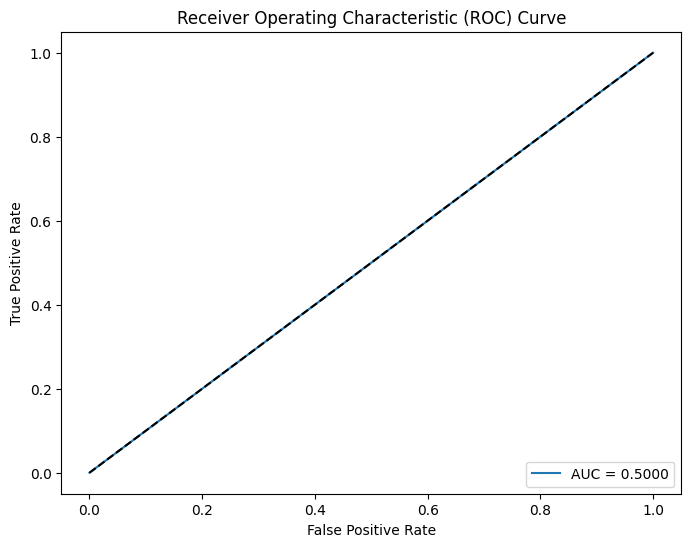

In [88]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# d1
[64, 16, 8, 4, 1]
- Accuracy:  0.7759562841530054
- Precision:  0.8767123287671232
- Recall:  0.847682119205298
- F1 Score:  0.861952861952862
- AUC Score:  0.642591059602649

[48, 48, 48, 48, 1]
- Accuracy:  0.7978142076502732
- Precision:  0.9014084507042254
- Recall:  0.847682119205298
- F1 Score:  0.8737201365187712
- AUC Score:  0.705091059602649

In [89]:
# main prediction

y_main_log = model.predict(X_test)
y_main_pred = np.where(y_main_log > 0.5, 1, 0)

conf_matrix = confusion_matrix(y_test, y_main_pred)

accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print("Accuracy: ", accuracy)

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
print("Precision: ", precision)

recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("Recall: ", recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score: ", f1_score)

auc_score = roc_auc_score(y_test, y_main_pred)
print("AUC Score: ", auc_score)

# print(classification_report(y_test, y_main_pred))

  1/172 [..............................] - ETA: 1s

172/172 [==============================] - 0s 618us/step
Accuracy:  0.6445575140832274
Precision:  nan
Recall:  0.0
F1 Score:  nan
AUC Score:  0.5


/tmp/ipykernel_1017537/3231427967.py:11: RuntimeWarning: invalid value encountered in long_scalars
  precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])


### get weights

In [ ]:
def plot_feature_importance(model, feature_names):
    # Get the weights of the first hidden layer
    first_hidden_layer_weights = model.layers[0].get_weights()[0]
    
    # Calculate the mean absolute weight for each feature
    feature_importance = np.mean(np.abs(first_hidden_layer_weights), axis=1)
    
    # Sort the features based on their importance
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_feature_importance = feature_importance[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    
    # Plot the feature importance
    plt.figure(figsize=(20, 6))
    plt.bar(range(len(feature_names)), sorted_feature_importance)
    plt.xticks(range(len(feature_names)), sorted_feature_names, rotation=45, ha='right')
    plt.xlabel('Feature')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance of MLP')
    plt.tight_layout()
    plt.show()


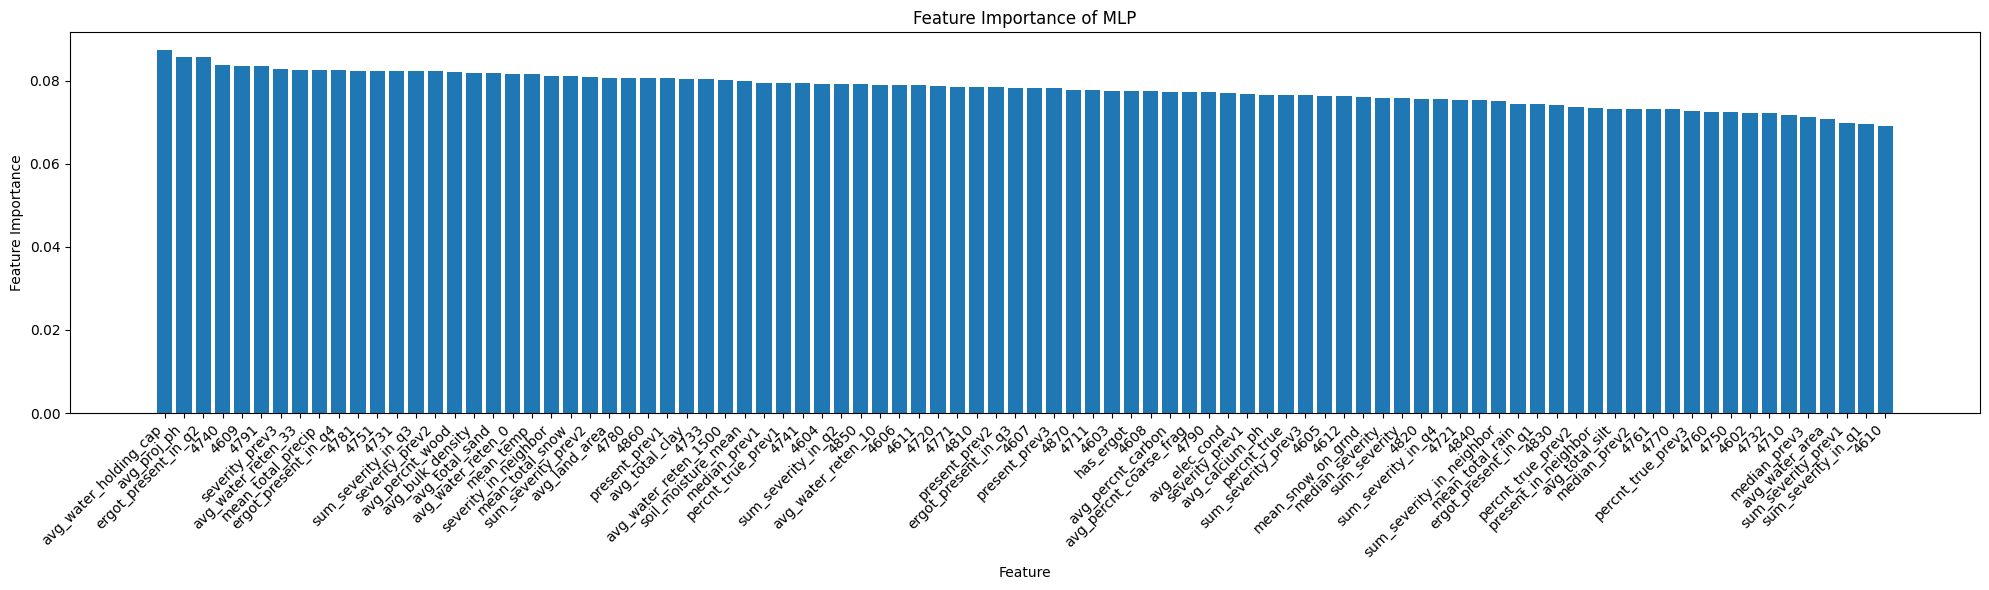

In [ ]:
plot_feature_importance(model, X_train_df.columns)

In [83]:
import tensorflow as tf
from tensorflow import keras
from kerastuner import HyperModel
from tensorflow.keras.metrics import AUC

class MyHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()

        # Tune the number of dense layers and units
        for i in range(hp.Int('num_dense_layers', 1, 3)):
            model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                      min_value=32,
                                                      max_value=512,
                                                      step=32),
                                        activation='relu'))

        model.add(keras.layers.Dense(self.num_classes, activation='sigmoid'))

        # Tune the learning rate for the optimizer
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        #               loss='binary_crossentropy',
        #               metrics=['accuracy'])

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='binary_crossentropy',
                      metrics=['accuracy', AUC(name='auc')])  # Add AUC metric

        return model


In [84]:
from kerastuner.tuners import BayesianOptimization

input_shape = (X_train.shape[1],)
num_classes = 1


import keras_tuner

# Define your hypermodel with the input shape and number of classes
hypermodel = MyHyperModel(input_shape=input_shape, num_classes=num_classes)

# Initialize the BayesianOptimization tuner with the objective set to maximize AUC
tuner = BayesianOptimization(
    hypermodel,
    objective=keras_tuner.Objective("val_auc", direction="max"),
    max_trials=10,
    overwrite=True,
    directory='my_tuner_dir',
    project_name='my_model_tuning'
)

# Start the hyperparameter search
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])



Trial 10 Complete [00h 00m 04s]
val_auc: 0.6324120759963989

Best val_auc So Far: 0.6601712107658386
Total elapsed time: 00h 00m 43s
INFO:tensorflow:Oracle triggered exit


In [85]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model with the best hyperparameters
best_model = hypermodel.build(best_hps)

# Train the best model on the full training data
best_model.fit(X_train, y_train,
               validation_data=(X_val, y_val),
               epochs=50,  # Use an appropriate number of epochs
               batch_size=32)  # Set a batch size that fits your data and hardware


Epoch 1/50
329/329 [==============================] - 1s 2ms/step - loss: 0.6419 - accuracy: 0.6431 - auc: 0.6028 - val_loss: 0.6102 - val_accuracy: 0.6550 - val_auc: 0.6306
Epoch 2/50
329/329 [==============================] - 1s 2ms/step - loss: 0.6179 - accuracy: 0.6470 - auc: 0.6179 - val_loss: 0.6002 - val_accuracy: 0.6577 - val_auc: 0.6371
Epoch 3/50
329/329 [==============================] - 1s 2ms/step - loss: 0.6118 - accuracy: 0.6459 - auc: 0.6287 - val_loss: 0.5999 - val_accuracy: 0.6577 - val_auc: 0.6348
Epoch 4/50
329/329 [==============================] - 1s 2ms/step - loss: 0.6048 - accuracy: 0.6466 - auc: 0.6400 - val_loss: 0.5928 - val_accuracy: 0.6577 - val_auc: 0.6457
Epoch 5/50
329/329 [==============================] - 1s 2ms/step - loss: 0.5994 - accuracy: 0.6475 - auc: 0.6400 - val_loss: 0.5861 - val_accuracy: 0.6565 - val_auc: 0.6503
Epoch 6/50
329/329 [==============================] - 1s 2ms/step - loss: 0.5893 - accuracy: 0.6474 - auc: 0.6518 - val_loss: 0.59

In [91]:
y_main_log = best_model.predict(X_val)
y_main_pred = np.where(y_main_log > 0.5, 1, 0)

conf_matrix = confusion_matrix(y_val, y_main_pred)

accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print("Accuracy: ", accuracy)

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
print("Precision: ", precision)

recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("Recall: ", recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score: ", f1_score)

auc_score = roc_auc_score(y_test, y_main_pred)
print("AUC Score: ", auc_score)


 1/83 [..............................] - ETA: 0s

83/83 [==============================] - 0s 739us/step
Accuracy:  0.6576747720364742
Precision:  nan
Recall:  0.0
F1 Score:  nan


/tmp/ipykernel_1017537/3213618399.py:9: RuntimeWarning: invalid value encountered in long_scalars
  precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])


ValueError: Found input variables with inconsistent numbers of samples: [5503, 2632]